In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 gkl1djt9


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-gkl1djt9:best, 58.47MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:10.0


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                         | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/330 [00:01<05:37,  1.02s/it]

  2%|██▋                                                                                                                                              | 6/330 [00:01<00:46,  6.90it/s]

  3%|████▊                                                                                                                                           | 11/330 [00:01<00:24, 13.11it/s]

  5%|██████▉                                                                                                                                         | 16/330 [00:01<00:16, 19.21it/s]

  6%|█████████▏                                                                                                                                      | 21/330 [00:01<00:12, 24.85it/s]

  8%|███████████▎                                                                                                                                    | 26/330 [00:01<00:10, 29.78it/s]

  9%|█████████████▌                                                                                                                                  | 31/330 [00:01<00:08, 33.87it/s]

 11%|███████████████▋                                                                                                                                | 36/330 [00:01<00:07, 37.13it/s]

 12%|█████████████████▉                                                                                                                              | 41/330 [00:01<00:07, 39.64it/s]

 14%|████████████████████                                                                                                                            | 46/330 [00:01<00:06, 41.54it/s]

 15%|██████████████████████▎                                                                                                                         | 51/330 [00:02<00:06, 42.92it/s]

 17%|████████████████████████▍                                                                                                                       | 56/330 [00:02<00:06, 43.94it/s]

 18%|██████████████████████████▌                                                                                                                     | 61/330 [00:02<00:06, 44.65it/s]

 20%|████████████████████████████▊                                                                                                                   | 66/330 [00:02<00:05, 45.16it/s]

 22%|██████████████████████████████▉                                                                                                                 | 71/330 [00:02<00:05, 45.53it/s]

 23%|█████████████████████████████████▏                                                                                                              | 76/330 [00:02<00:05, 45.80it/s]

 25%|███████████████████████████████████▎                                                                                                            | 81/330 [00:02<00:05, 45.98it/s]

 26%|█████████████████████████████████████▌                                                                                                          | 86/330 [00:02<00:05, 46.11it/s]

 28%|███████████████████████████████████████▋                                                                                                        | 91/330 [00:02<00:05, 46.20it/s]

 29%|█████████████████████████████████████████▉                                                                                                      | 96/330 [00:03<00:05, 46.24it/s]

 31%|███████████████████████████████████████████▊                                                                                                   | 101/330 [00:03<00:04, 46.31it/s]

 32%|█████████████████████████████████████████████▉                                                                                                 | 106/330 [00:03<00:04, 46.34it/s]

 34%|████████████████████████████████████████████████                                                                                               | 111/330 [00:03<00:04, 46.37it/s]

 35%|██████████████████████████████████████████████████▎                                                                                            | 116/330 [00:03<00:04, 46.37it/s]

 37%|████████████████████████████████████████████████████▍                                                                                          | 121/330 [00:03<00:04, 46.38it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                        | 126/330 [00:03<00:04, 46.38it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                      | 131/330 [00:03<00:04, 46.39it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                    | 136/330 [00:03<00:04, 46.40it/s]

 43%|█████████████████████████████████████████████████████████████                                                                                  | 141/330 [00:04<00:04, 46.40it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                               | 146/330 [00:04<00:03, 46.40it/s]

 46%|█████████████████████████████████████████████████████████████████▍                                                                             | 151/330 [00:04<00:03, 46.41it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 156/330 [00:04<00:03, 46.39it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 161/330 [00:04<00:03, 46.38it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 166/330 [00:04<00:03, 46.40it/s]

 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 171/330 [00:04<00:03, 46.40it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                  | 176/330 [00:04<00:03, 46.40it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▍                                                                | 181/330 [00:04<00:03, 46.41it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 186/330 [00:05<00:03, 46.42it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 191/330 [00:05<00:02, 46.41it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                          | 196/330 [00:05<00:02, 46.39it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 201/330 [00:05<00:02, 46.41it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 206/330 [00:05<00:02, 46.43it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 211/330 [00:05<00:02, 46.21it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 216/330 [00:05<00:02, 45.37it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 221/330 [00:05<00:02, 44.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 226/330 [00:05<00:02, 44.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 231/330 [00:06<00:02, 44.13it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 236/330 [00:06<00:02, 43.95it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 241/330 [00:06<00:02, 43.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 246/330 [00:06<00:01, 43.73it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 251/330 [00:06<00:01, 43.65it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 256/330 [00:06<00:01, 43.61it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 261/330 [00:06<00:01, 43.59it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 266/330 [00:06<00:01, 43.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 271/330 [00:06<00:01, 43.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 276/330 [00:07<00:01, 43.52it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 281/330 [00:07<00:01, 43.51it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 286/330 [00:07<00:01, 43.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 291/330 [00:07<00:00, 43.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 296/330 [00:07<00:00, 43.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 301/330 [00:07<00:00, 43.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 306/330 [00:07<00:00, 43.51it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 311/330 [00:07<00:00, 43.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 316/330 [00:07<00:00, 43.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 321/330 [00:08<00:00, 43.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 326/330 [00:08<00:00, 43.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:08<00:00, 39.65it/s]

train - OK


  0%|                                                                                                                                                          | 0/42 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                              | 1/42 [00:00<00:05,  7.61it/s]

 14%|████████████████████▊                                                                                                                             | 6/42 [00:00<00:01, 27.22it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 11/42 [00:00<00:00, 34.14it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 16/42 [00:00<00:00, 37.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 21/42 [00:00<00:00, 39.48it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 26/42 [00:00<00:00, 40.67it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 31/42 [00:00<00:00, 41.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 36/42 [00:00<00:00, 41.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 41/42 [00:01<00:00, 42.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 36.49it/s]

val - OK


  0%|                                                                                                                                                          | 0/23 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                           | 1/23 [00:00<00:03,  7.11it/s]

 26%|██████████████████████████████████████                                                                                                            | 6/23 [00:00<00:00, 26.52it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 11/23 [00:00<00:00, 33.72it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 16/23 [00:00<00:00, 37.30it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 21/23 [00:00<00:00, 39.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.06it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                | 1/138 [00:00<00:19,  6.94it/s]

  4%|██████▎                                                                                                                                          | 6/138 [00:00<00:05, 26.22it/s]

  8%|███████████▍                                                                                                                                    | 11/138 [00:00<00:03, 33.56it/s]

 12%|████████████████▋                                                                                                                               | 16/138 [00:00<00:03, 37.14it/s]

 15%|█████████████████████▉                                                                                                                          | 21/138 [00:00<00:02, 39.29it/s]

 19%|███████████████████████████▏                                                                                                                    | 26/138 [00:00<00:02, 40.54it/s]

 22%|████████████████████████████████▎                                                                                                               | 31/138 [00:00<00:02, 41.32it/s]

 26%|█████████████████████████████████████▌                                                                                                          | 36/138 [00:00<00:02, 41.98it/s]

 30%|██████████████████████████████████████████▊                                                                                                     | 41/138 [00:01<00:02, 42.37it/s]

 33%|████████████████████████████████████████████████                                                                                                | 46/138 [00:01<00:02, 42.63it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                          | 51/138 [00:01<00:02, 42.76it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 56/138 [00:01<00:01, 42.91it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 61/138 [00:01<00:01, 42.93it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 66/138 [00:01<00:01, 43.01it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                      | 71/138 [00:01<00:01, 43.11it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 76/138 [00:01<00:01, 43.16it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 81/138 [00:01<00:01, 43.21it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 86/138 [00:02<00:01, 43.23it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 91/138 [00:02<00:01, 43.25it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96/138 [00:02<00:00, 43.25it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 101/138 [00:02<00:00, 43.27it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 106/138 [00:02<00:00, 43.27it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 111/138 [00:02<00:00, 43.28it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 116/138 [00:02<00:00, 43.31it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 121/138 [00:02<00:00, 43.28it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 126/138 [00:03<00:00, 43.30it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 131/138 [00:03<00:00, 43.32it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 136/138 [00:03<00:00, 43.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:03<00:00, 40.76it/s]

test OoD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:02, 44.67it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:00<00:02, 44.82it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:00<00:01, 44.91it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:00<00:01, 44.99it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:00<00:01, 45.04it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:00<00:01, 45.08it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:00<00:01, 45.10it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:00<00:01, 45.12it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:00<00:01, 45.13it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:01<00:01, 45.14it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:01<00:00, 45.14it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:00, 45.15it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:01<00:00, 45.15it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:01<00:00, 45.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:01<00:00, 45.15it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:01<00:00, 45.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:01<00:00, 45.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:01<00:00, 45.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:02<00:00, 45.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.10it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269,)
(2928, 1, 64, 64) (2928, 1, 64, 64) (2928, 512) (2928,)
(17568, 1, 64, 64) (17568, 1, 64, 64) (17568, 512) (17568,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)


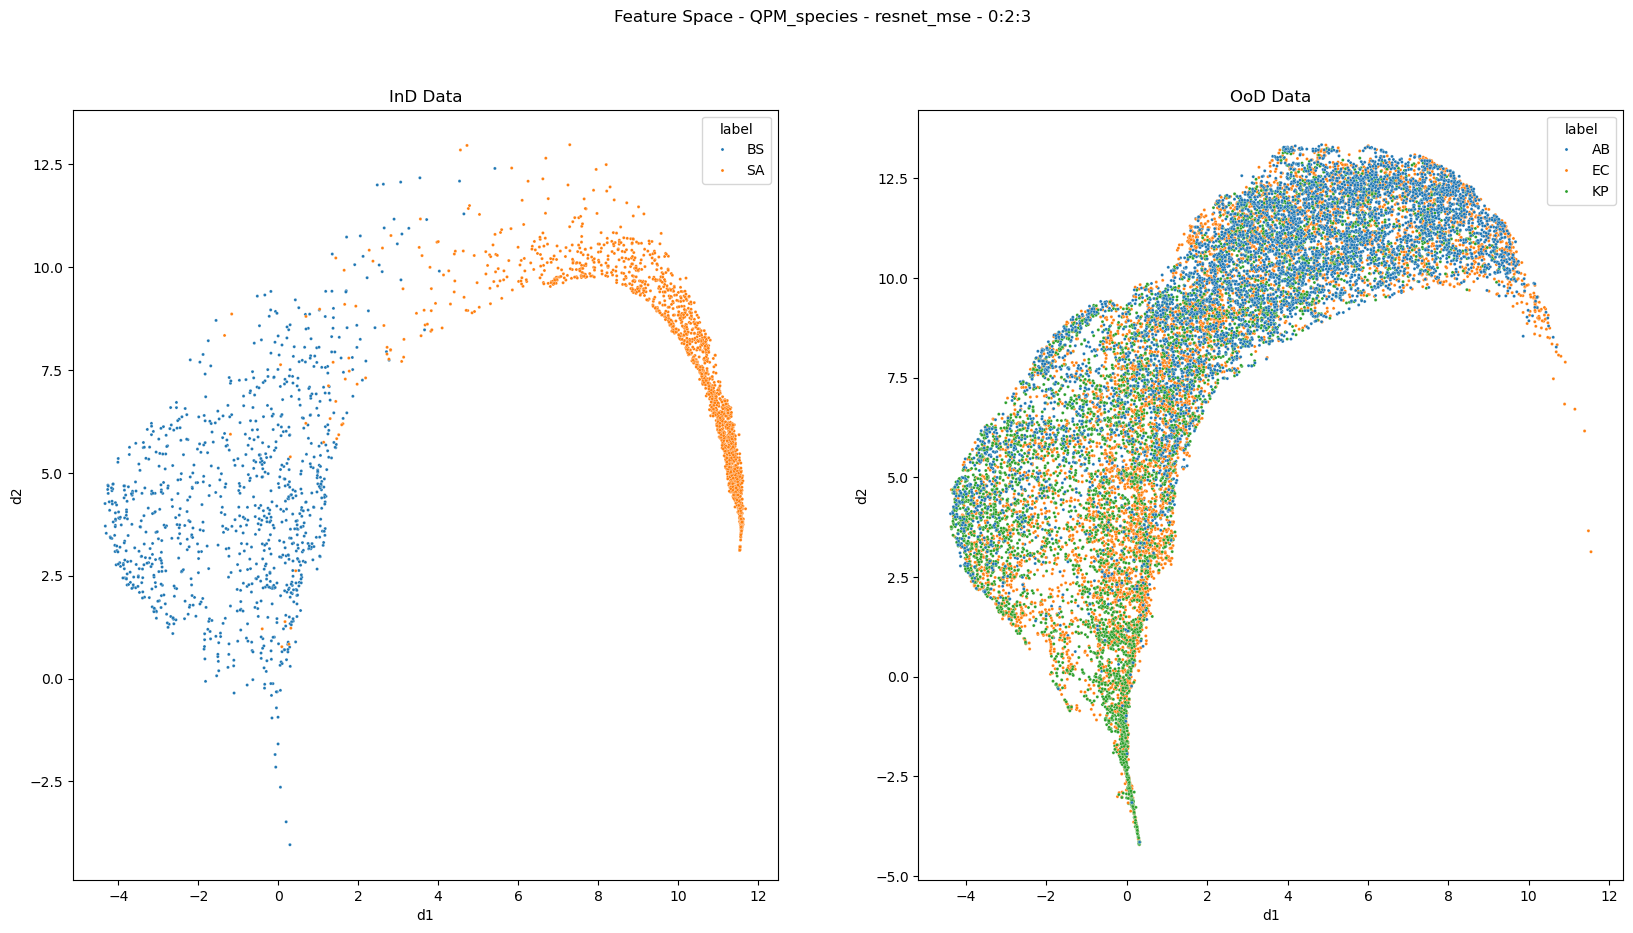

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

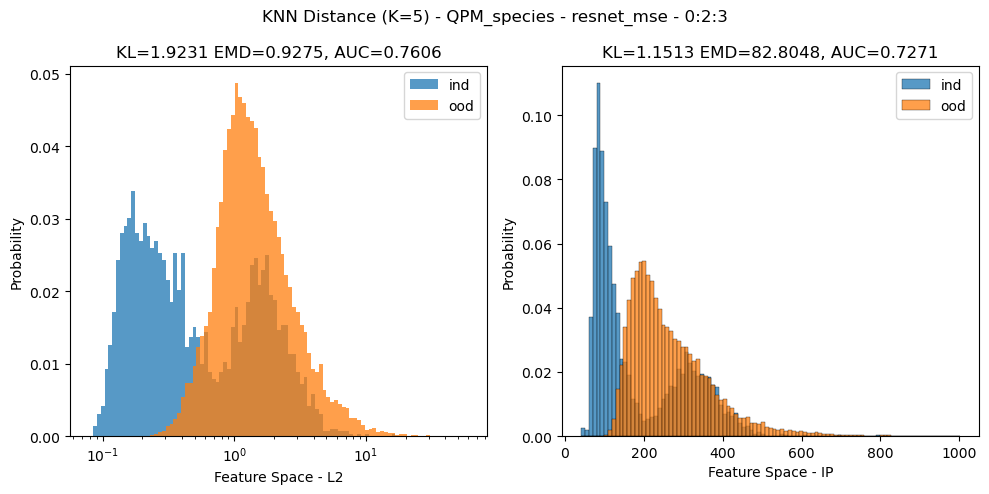

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

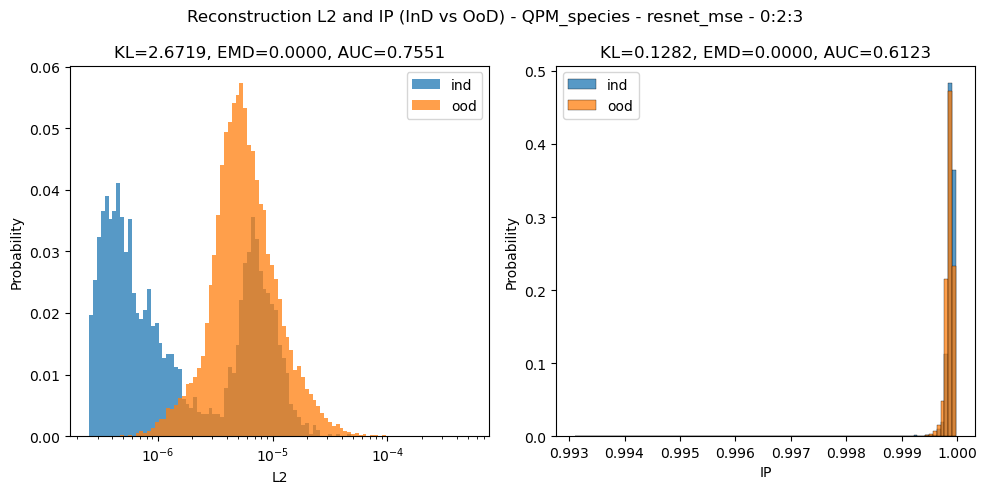

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)